<a href="https://colab.research.google.com/github/abhiraman/Capstone_Project/blob/main/Text_Detection_Detectron2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#! git clone https://github.com/eriklindernoren/PyTorch-YOLOv3

In [ ]:
# install dependencies: 
!pip install pyyaml==5.1.2
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

1.8.1+cu101 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [ ]:
# install detectron2: (Colab has CUDA 10.1 + torch 1.8)
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
import torch
assert torch.__version__.startswith("1.8")   # need to manually install torch 1.8 if Colab changes its default version
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
# exit(0)  # After installation, you need to "restart runtime" in Colab. This line can also restart runtime

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html


In [ ]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

Run on a smaple Image 

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


In [ ]:
!ls
%cd My Drive/Capstone_project_data/Synthetic Train Set - Detection & Recognition

MyDrive
/gdrive/My Drive/Capstone_project_data/Synthetic Train Set - Detection & Recognition


In [ ]:
!ls

Annotation  Images  input.jpg  output  readme.txt  train_crop_annot.txt


# Unzip the Custom Data

In [ ]:
#!unzip 'Synthetic Train Set - Detection & Recognition.zip'

# Store Data in Detectron2 format 

In [ ]:
from detectron2.structures import BoxMode

def get_text_dicts(img_dir,annot_directory,view_data = False):
    print("annot_directory",annot_directory)
    
     ## read a text File ## 
    if view_data:
      all_text_files = os.listdir(annot_directory)[:4]
    else:
      all_text_files = os.listdir(annot_directory)[0:500]
    #print("all_text_files",all_text_files)

    dataset_dicts = []
    for e_file in all_text_files:
        record = {}
        
        filename = os.path.join(img_dir, e_file.replace('.txt','.jpg'))
        #print("filename",filename)
        try:
          height, width = cv2.imread(filename).shape[:2]
        except:
          continue
        
        record["file_name"] = filename
        record["image_id"] = e_file.strip('.txt')
        record["height"] = height
        record["width"] = width
      
        objs = []
        annot_file_name = os.path.join(annot_directory,e_file)
        with open(annot_file_name,'r') as fh:
            all_lines = fh.readlines()
        
        fh.close()
        for e_line in all_lines:
         # print(e_line)
          split_list = e_line.split(' ')
          px = [float(e_str) for e_str in split_list[0:4]]
          py = [float(e_str) for e_str in split_list[4:8]]
          poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
          poly = [p for x in poly for p in x]
          obj = {
              "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
              "bbox_mode": BoxMode.XYXY_ABS,
              "segmentation": [poly],
              "category_id": 0,
          }
          objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

In [ ]:
# for i in ["Train","Val"]:
#   if i == "Train":
#     ## Train 23 Folders of 25 ##
#     d = 24
#     DatasetCatalog.register("TextIdentifier_" +"Train", lambda d=d: [get_text_dicts("./Images/"+str(e_f),"./Annotation/"+str(e_f)) for e_f in range(1,d)])
#     MetadataCatalog.get("TextIdentifier_" +"Train").set(thing_classes=["Text"])
#   else:
#     DatasetCatalog.register("TextIdentifier_" +"Val", lambda d=d: [get_text_dicts("./Images/"+str(e_f),"./Annotation/"+str(e_f)) for e_f in range(d,26)])
#     MetadataCatalog.get("TextIdentifier_" +"Val").set(thing_classes=["Text"])




In [ ]:
for d in range(1,15):
  d = str(d)
  try:
    DatasetCatalog.register("./Images/" +d, lambda d=d: get_text_dicts("./Images/"+d,"./Annotation/"+d))
    MetadataCatalog.get("./Images/" +d).set(thing_classes=["Text"])
  except:
    pass
  # else:
  #   DatasetCatalog.register("TextIdentifier_" +"Val", lambda d=d: [get_text_dicts("./Images/"+str(e_f),"./Annotation/"+str(e_f)) for e_f in range(d,26)])
  #   MetadataCatalog.get("TextIdentifier_" +"Val").set(thing_classes=["Text"])




In [ ]:
import re
all_datasets = list(DatasetCatalog.data.keys())
pattern = re.compile("./Images/")

custom_dataset = (e_dataset for e_dataset in all_datasets if re.match(pattern,e_dataset)!=None)
custom_dataset = tuple(custom_dataset)
print("custom_dataset",custom_dataset)

custom_dataset ('./Images/1', './Images/2', './Images/3', './Images/4', './Images/5', './Images/6', './Images/7', './Images/8', './Images/9', './Images/10', './Images/11', './Images/12', './Images/13', './Images/14')


# View Sample Data 

annot_directory ./Annotation/9


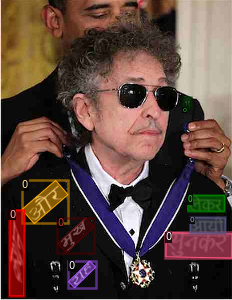

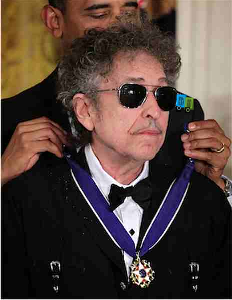

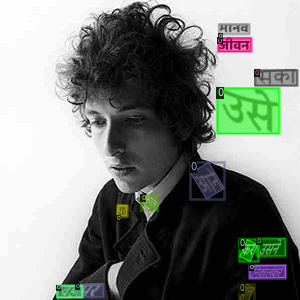

In [ ]:
dd = str(np.random.randint(1,25))
TextIdentifier_MData = MetadataCatalog.get("./Image/"+dd)
dataset_dicts = get_text_dicts("./Images/"+dd,"./Annotation/"+dd,view_data=True)
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=TextIdentifier_MData, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    cv2_imshow(out.get_image()[:, :, ::-1])

# Pre-Train Model With CoCo Set & Train with Custom Set

In [ ]:
cfg = get_cfg()

In [ ]:
from detectron2.engine import DefaultTrainer


cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = custom_dataset
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.0025  # pick a good Learning Rate
cfg.SOLVER.MAX_ITER = 2000   
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256   #(default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class ("Text"). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)

trainer.resume_or_load(resume=False)
trainer.train()

# Training Plots

In [ ]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output

## Inference & evaluation using the trained model


In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
print(cfg.MODEL.WEIGHTS)
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

./output/model_final.pth


Skip loading parameter 'proposal_generator.rpn_head.conv.weight' to the model due to incompatible shapes: (256, 256, 3, 3) in the checkpoint but (1024, 1024, 3, 3) in the model! You might want to double check if this is expected.
Skip loading parameter 'proposal_generator.rpn_head.conv.bias' to the model due to incompatible shapes: (256,) in the checkpoint but (1024,) in the model! You might want to double check if this is expected.
Skip loading parameter 'proposal_generator.rpn_head.objectness_logits.weight' to the model due to incompatible shapes: (3, 256, 1, 1) in the checkpoint but (15, 1024, 1, 1) in the model! You might want to double check if this is expected.
Skip loading parameter 'proposal_generator.rpn_head.objectness_logits.bias' to the model due to incompatible shapes: (3,) in the checkpoint but (15,) in the model! You might want to double check if this is expected.
Skip loading parameter 'proposal_generator.rpn_head.anchor_deltas.weight' to the model due to incompatible s

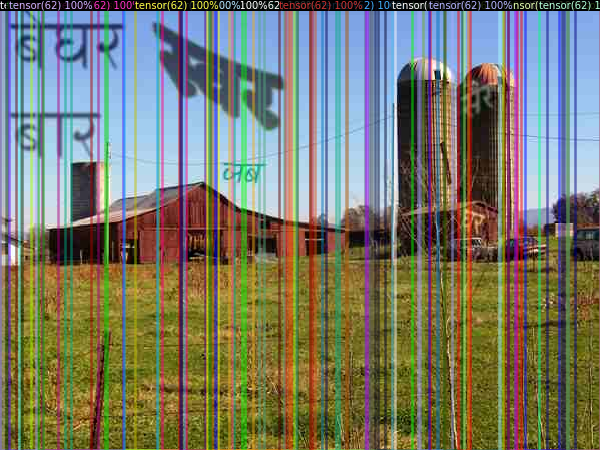

In [ ]:
all_test_images = os.listdir(r"./Images/25")
for i in range(1):    
  ind = random.randint(0,len(all_test_images))
  file_name = all_test_images[ind]
  full_path = os.path.join("./Images/25",file_name)
  inputs = cv2.imread(full_path)
  #print(inputs)
  outputs = predictor(inputs)
#predictor = DefaultPredictor(cfg)
#print("outputs",outputs)
from detectron2.utils.visualizer import ColorMode
v = Visualizer(inputs[:, :, ::-1],metadata=None,scale=1,instance_mode=ColorMode.IMAGE_BW )  # remove the colors of unsegmented pixels. This option is only available for segmentation models
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])

In [ ]:
all_test_images = os.listdir(r"./Test Image")
for i in range(1):    
  ind = random.randint(0,len(all_test_images))
  file_name = all_test_images[ind]
  full_path = os.path.join("./Test Image",file_name)
  inputs = cv2.imread(full_path)
  #print(inputs)
  outputs = predictor(inputs)
#predictor = DefaultPredictor(cfg)
#print("outputs",outputs)
from detectron2.utils.visualizer import ColorMode
v = Visualizer(inputs[:, :, ::-1],metadata=None,scale=1,instance_mode=ColorMode.IMAGE_BW )  # remove the colors of unsegmented pixels. This option is only available for segmentation models
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])